# Testing the linearity of the data using the calibration source
### J.-Ch. Hamilton - D. Mennella - March 2019

In this notebook we investigate the linearity of the TES by using the calibration source modulated with sine waves of different amplitudes. We basically plot the TES data against the source data be it measured with the power meter of the calibration or with a model of the source signal accounting for instrinsic non linearity of the source signal.

The data was taken with Eccosorb on the QUBIC window in order to induce high diffusion of the incoming source signal, therefore low coherence, hence low interferences. In such a way we do no longer see the synthesized beam on the focal plane but instead a rather uniform signal that is well adapted to this study.

We first need to import some libraries:

In [3]:
##### Notebook configuration
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(12,10))
rc('font',size=12)
rc('text',usetex=False)

##MyPath
import sys
sys.path.insert(0,'/home/james/eclipse-workspace/qubiclmou/qubic/')
sys.path.insert(0,'/home/james/eclipse-workspace/qubiclmou/qubic/qubic/scripts/Calibration/')

###### Stabdard Libraries
import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import datetime as dt

###### Specific QUBIC libraries
from qubicpack import qubicpack as qp
import fibtools as ft
import lin_lib as ll

### Reading the data

There datasets to be anayzed are:
- Constant offset of 2.5V and amplitudes ranging from 1.25 to 5V. The data was taken on March 1st 2019
- for each of these we have the calibration source data in the hk directory of the data saved by QubicStudio

In the following cell we read the corresponding filenames and order them, detect the offsets, amplitudes and modulation frequencies. We order the files by the amplitude of the modulation.

In [5]:
day = '2019-03-01'
#data_dir = '/qubic/Data/Calib-TD/'+day+'/'
data_dir = '/home/james/TDCalibData/Calib-TD/'+day+'/'
dirs = np.array(glob.glob(data_dir+'/*LinearityA*'))
dirs.sort()

labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
labels = np.array(labels)

modfreqs = np.zeros(len(labels))
amps = np.zeros(len(labels))
offsets = np.zeros(len(labels))
for i in xrange(len(labels)):
    bla = str.split(labels[i],'_')
    modfreqs[i] = np.float(bla[2][0:len(bla[2])-2])
    amps[i] = np.float(bla[4])
    offsets[i] = np.float(bla[6])

    
order = np.argsort(amps)
modfreqs = modfreqs[order]
amps = amps[order]
offsets = offsets[order]
labels = labels[order]
dirs = dirs[order]
print 'File Directories:'
print(dirs)

File Directories:
['/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500'
 '/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_

And there are source data associated, that are read below. It contains time (computer-time from the rasberry pi) and amplitude of the power-meter. We read them all for this day and concatenate them. Later we'll pick the common period corresponding to each data file.

['/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T133531.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T133828.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T134131.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T134435.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T134754.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T135053.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T135340.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T135631.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T135925.dat', '/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T140226.dat'] <type 'list'>
/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T133531.dat
/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T133828.dat
/home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T134131.dat
/home/

Text(0.5,0,'Time (s)')

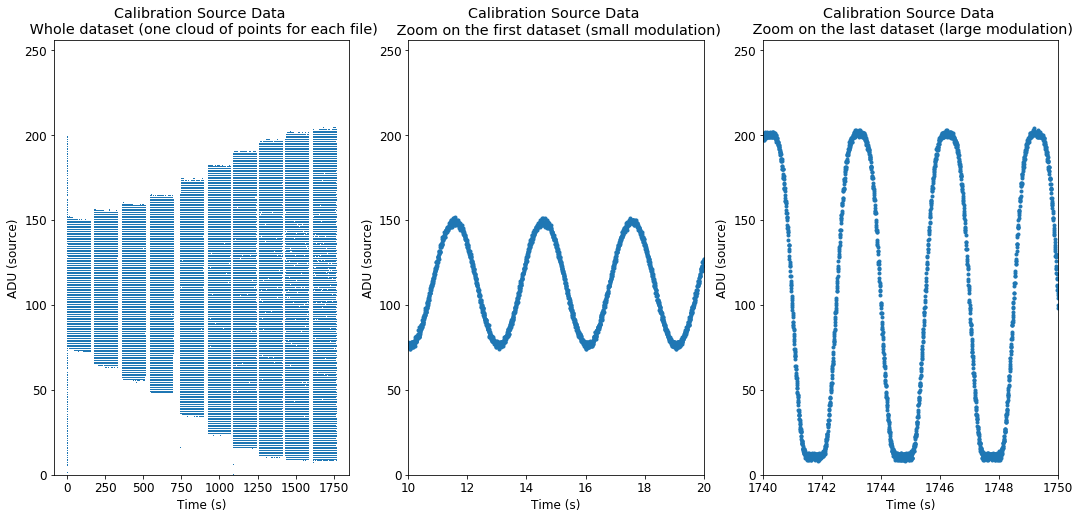

In [10]:
##### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
#fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc = glob.glob('/home/james/TDCalibData/Calib-TD/calsource/*'+daycalsrc+'*.dat')
fcalsrc.sort()
print fcalsrc, type(fcalsrc)

ttsrc = []
ddsrc = []
for ff in fcalsrc:
    print ff
    thett, thedd = np.loadtxt(ff).T
    ttsrc.append(thett+3600)
    ddsrc.append(thedd)
    
ttsrc = np.concatenate(ttsrc)
ddsrc = np.concatenate(ddsrc)

############### Plot this data
rc('figure',figsize=(18,8))
subplot(1,3,1)
plot(ttsrc-min(ttsrc),ddsrc,',')
ylim(0,256)
title('Calibration Source Data \n Whole dataset (one cloud of points for each file)')
ylabel('ADU (source)')
xlabel('Time (s)')

subplot(1,3,2)
plot(ttsrc-min(ttsrc),ddsrc,'.')
ylim(0,256)
xlim(10, 20)
title('Calibration Source Data \n Zoom on the first dataset (small modulation)')
ylabel('ADU (source)')
xlabel('Time (s)')

subplot(1,3,3)
plot(ttsrc-min(ttsrc),ddsrc,'.')
ylim(0,256)
xlim(1740, 1750)
title('Calibration Source Data \n Zoom on the last dataset (large modulation)')
ylabel('ADU (source)')
xlabel('Time (s)')


Now we read the data for both asics and for each TES, we only keep the data for which the source data is common with the TES data.

In [11]:
tt = []
dd = []
tt_src = []
dd_src = []
for thedir in dirs:
    print 'Directory :'
    print '-----------'
    print(thedir)
    dd_asic = []
    tt_asic = []
    dd_src_asic = []
    tt_src_asic = []    
    for asicnum in [1,2]:
        print 'ASIC Number: {}'.format(asicnum) 
        print '------------' 
        a = qp()
        a.read_qubicstudio_dataset(thedir, asic=asicnum)
        FREQ_SAMPLING = 1./a.sample_period()
        
        ######## Getting the time axis #############################
        #### Old version: no PPS, data timeline is just a linspace
        #t_data = a.timeline_timeaxis(axistype='index')
        #t0 = a.timeline_timeaxis(axistype='pps')[0]
        #t_data = t_data + t0
        #### NEW version with PPS accounted for - Used to have a bug - to be checked now
        #t_data = a.timeline_timeaxis(axistype='pps')
        #t0 = t_data[0]
        #### Latest version from Steve on March 13th
        #pps=a.pps()
        #gps=a.gps()
        #t_data = a.pps2date(pps,gps)
        #print('0',np.shape(t_data), np.shape(a.timeline_timeaxis(axistype='index')))
        #t0 = t_data[0]
        #### Bricolage
        t_data = a.timeline_timeaxis(axistype='index')
        pps=a.pps()
        gps=a.gps()
        t0 = np.min(a.pps2date(pps,gps))
        t_data = t_data + t0
        #############################################################
        

        #################### Getting regions of common data between source and data ###############
        ### Find the region where there is source data
        print 'Data Times'
        print np.min(t_data), np.max(t_data)
        print 'Src Dates'
        print np.min(ttsrc), np.max(ttsrc)
        oksrc = (ttsrc >= (t_data[0])) & (ttsrc <=(t_data[-1]))
        print 'Number of common points: {}'.format(oksrc.sum())
        thettsrc = ttsrc[oksrc]
        theddsrc = ddsrc[oksrc]
        ### now reduce each to matching regions
        mini = np.max([np.min(t_data), np.min(thettsrc)])
        maxi = np.min([np.max(t_data), np.max(thettsrc)])
        okdata = (t_data >= mini) & (t_data <= maxi)
        print('T ',np.shape(t_data), np.shape(okdata), okdata.sum())
        oksrc = (thettsrc >= mini) & (thettsrc <= maxi)
        t_data = t_data[okdata]
        thettsrc = thettsrc[oksrc]
        theddsrc = theddsrc[oksrc]
        # APpend these to the asic data
        tt_asic.append(t_data-t0)
        tt_src_asic.append(thettsrc-t0)
        dd_src_asic.append(theddsrc)
        ############################################################################################
        
        nsamples = len(t_data)
        alldata = np.zeros((128, nsamples))
        print(np.shape(alldata))
        for TESindex in xrange(128):
            TESnum = TESindex + 1
            ######## Getting the data and reduce it to relevant region (w.r.t. source data)
            data = a.timeline(TES=TESnum)
            #print(TESindex,np.shape(okdata), np.shape(data))
            alldata[TESindex,:] = data[okdata]
            
        # Append this data to the ddasic variable    
        dd_asic.append(alldata)

    tt.append(tt_asic)
    dd.append(dd_asic)
    tt_src.append(tt_src_asic)
    dd_src.append(dd_src_asic)

Directory :
-----------
/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
ASIC Number: 1
------------
Reading data for ASIC 1
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Guessing the detector array is: P87
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/conf-asics-2019.03.01.143525.fits
There are 31 housekeeping measurements in the period 2019-03-01 13:35:26 to 2019-03-01 13:37:57
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-extern-2019.03.01.143526.fits
TES temperatures varies between -1000.0mK and -1000.0mK during the measurement
Using TES temperature -1000.0mK
Reading QubicStudio FITS file: /home/ja

No MMR data found in directory: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks/hk-MGC-2019.03.01.144125.fits
trying to find calsource data
found calsource file which started 6.0 seconds before the data acquisition
reading calsource file: /home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T134131.fits
mean pps interval is 1.0000 second
max pps interval is  1.0000 second
min pps interval is  1.0000 second
Data Times
1551447692.0 1551447847.68
Src Dates
1551447331.774819 1551449096.246846
Number of common points: 31902
('T ', (24326,), (24326,), 23356)
(128, 23356)
ASIC Number: 2
------------
Reading data for ASIC 2
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Sums/science-asic2-201

Reading data for ASIC 2
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic2-2019.03.01.144748.fits
Guessing the detector array is: P87
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/conf-asics-2019.03.01.144749.fits
There are 31 housekeeping measurements in the period 2019-03-01 13:47:49 to 2019-03-01 13:50:20
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/hk-extern-2019.03.01.144748.fits
TES temperatures varies between -1000.0mK and -1000.0mK during the measurement
Using TES temperature -1000.0mK
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/hk-intern-2019.03.01.144748.fits
No MMR data found in di

No MMR data found in directory: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks/hk-MGC-2019.03.01.145334.fits
trying to find calsource data
found calsource file which started 5.7 seconds before the data acquisition
reading calsource file: /home/james/TDCalibData/Calib-TD/calsource/calsource_20190301T135340.fits
mean pps interval is 2.5510 second
max pps interval is  38.0000 second
min pps interval is  1.0000 second
Data Times
1551448421.2 1551448575.7664
Src Dates
1551447331.774819 1551449096.246846
Number of common points: 32215
('T ', (24152,), (24152,), 23368)
(128, 23368)
Directory :
-----------
/home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500
ASIC Number: 1
------------
Reading data for ASIC 1
Reading QubicStudio FITS f

Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Sums/science-asic1-2019.03.01.150219.fits
Guessing the detector array is: P87
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Hks/conf-asics-2019.03.01.150221.fits
There are 31 housekeeping measurements in the period 2019-03-01 14:02:23 to 2019-03-01 14:04:54
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Hks/hk-extern-2019.03.01.150220.fits
TES temperatures varies between -1000.0mK and -1000.0mK during the measurement
Using TES temperature -1000.0mK
Reading QubicStudio FITS file: /home/james/TDCalibData/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Hks/hk-intern-2019.03.01.150219.fits
No MMR data found in directory: /home/james/TDC

# Analysis

## Folding the data and fitting with the source data

We now fold the data into a period of the modulation frequency with a given binning. The data is then fit with two different curves:
* The source data itself coming from the power meter, shifted in phase, amplitude and offset [NB we should not have to fit the phase but for now there probably remains a synchronization issue that is solved by this phase-shift)
* The model of the source signal accounting for the source instrinsic non-linearity at a given modulation amplitude and offset.

The code also exists for fitting with sine wave for which we fix the frequency to that of the source. However it is commented below as this is not very interesting: the source is not linear and therefore badly modelled by a sine wave.

In [7]:
reload(ll)

nbins = 50
allfolded = np.zeros((len(dirs), 2, 128, nbins))
allfolded_error = np.zeros((len(dirs), 2, 128, nbins))
allfolded_src = np.zeros((len(dirs), 2, 128, nbins))
allresfit = np.zeros((len(dirs), 2, 128, 4))
allerrfit = np.zeros((len(dirs), 2, 128, 4))
allresfit_src = np.zeros((len(dirs), 2, 128, 3))
allerrfit_src = np.zeros((len(dirs), 2, 128, 3))
allresfit_src_model = np.zeros((len(dirs), 2, 128, 6))
allerrfit_src_model = np.zeros((len(dirs), 2, 128, 6))

for ii in xrange(len(dirs)):
    print('Directory {}/{} : {}'.format(ii+1, len(dirs), dirs[ii]))
    modulation_frequency = modfreqs[ii]
    for asicindex in xrange(2):
        print('   Asic {}'.format(asicindex+1))
        ##### Folding Data
        #print('        - Folding data')
        time = tt[ii][asicindex]
        ns = len(time)
        tesdata = -dd[ii][asicindex]   # Minus sign in order to have positive power in positive direction
        folded, t, folded_nonorm, dy = ft.fold_data(time, tesdata, 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                                    notch=None, return_error=True, silent=True)
        allfolded[ii, asicindex, :, :] = folded_nonorm
        allfolded_error[ii, asicindex, :, :] = dy

        ##### Folding Source data
        #print('        - Folding Source')
        srctime = tt_src[ii][asicindex]
        srcdata = np.reshape(dd_src[ii][asicindex], (1,len(dd_src[ii][asicindex])))
        folded_src, tsrc, folded_nonorm_src, dy_src = ft.fold_data(srctime, srcdata, 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                            notch=None, return_error=True, silent=True)
        allfolded_src[ii,asicindex, :, :] = folded_nonorm_src
        
        ##### Now fitting each TES with the curves
        #print('        - Fitting Sine for all TES')
#         for TESindex in xrange(128):
#             ##### Fitting folded data with a sine
#             guess = np.array([5000.*amps[ii], 1./modulation_frequency, 1.,0.])
#             res = ft.do_minuit(t,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
#                                guess, functname=ll.sine, fixpars=[0,1,0,0],verbose=False, force_chi2_ndf=True)
#             allresfit[ii, asicindex, TESindex, :] = res[1]
#             allerrfit[ii, asicindex, TESindex, :] = res[2]

        #print('        - Fitting CalSrc data for all TES')
        for TESindex in xrange(128):
            ##### Fitting a possible shift in t and y to source data
            guess = np.array([600, 0.1,100])
            xyper = [tsrc,allfolded_src[ii, asicindex, TESindex, :], 1./modulation_frequency]
            res = ft.do_minuit(xyper,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
                                guess, functname=ll.shift_src, fixpars=[0,0,0],verbose=False, force_chi2_ndf=True, nohesse=True)
            allresfit_src[ii, asicindex, TESindex,:] = res[1]
            allerrfit_src[ii, asicindex, TESindex,:] = res[2]    
    
        #print('        - Fitting CalSrc Model for all TES')
        for TESindex in xrange(128):
            ##### Fitting The model source data
            guess = np.array([600, np.mean(allfolded[ii, asicindex, TESindex:]),  
                              amps[ii], 1./modfreqs[ii],np.mean(t), offsets[ii]])
            res = ft.do_minuit(t,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
                                guess, functname=ll.sinesat, fixpars=[0,0,1,1,0,1],verbose=False, force_chi2_ndf=True, nohesse=True)
            allresfit_src_model[ii, asicindex, TESindex,:] = res[1]
            allerrfit_src_model[ii, asicindex, TESindex,:] = res[2]

Directory 1/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
   Asic 1
   Asic 2
Directory 2/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500
   Asic 1
   Asic 2
Directory 3/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500
   Asic 1
   Asic 2
Directory 4/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500
   Asic 1
   Asic 2
Directory 5/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500
   Asic 1
   Asic 2
Directory 6/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500
   Asic 1
   Asic 2
Directory 7/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500
   Asic 1
   Asic 2
Directory 8/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25_

Next cell is just a plot of the previous calculations for the selected asic and TES. Normally one sees the saturation effect on the calsrc and the data for the files corresponding to large modulation amplitude of the source. This obvious non linearity is NOT that of the TES but rather that of the source itself.

You can change the ASIC number and the TES number in the first two lines of the cell in order to display the data for your favourite pixel.

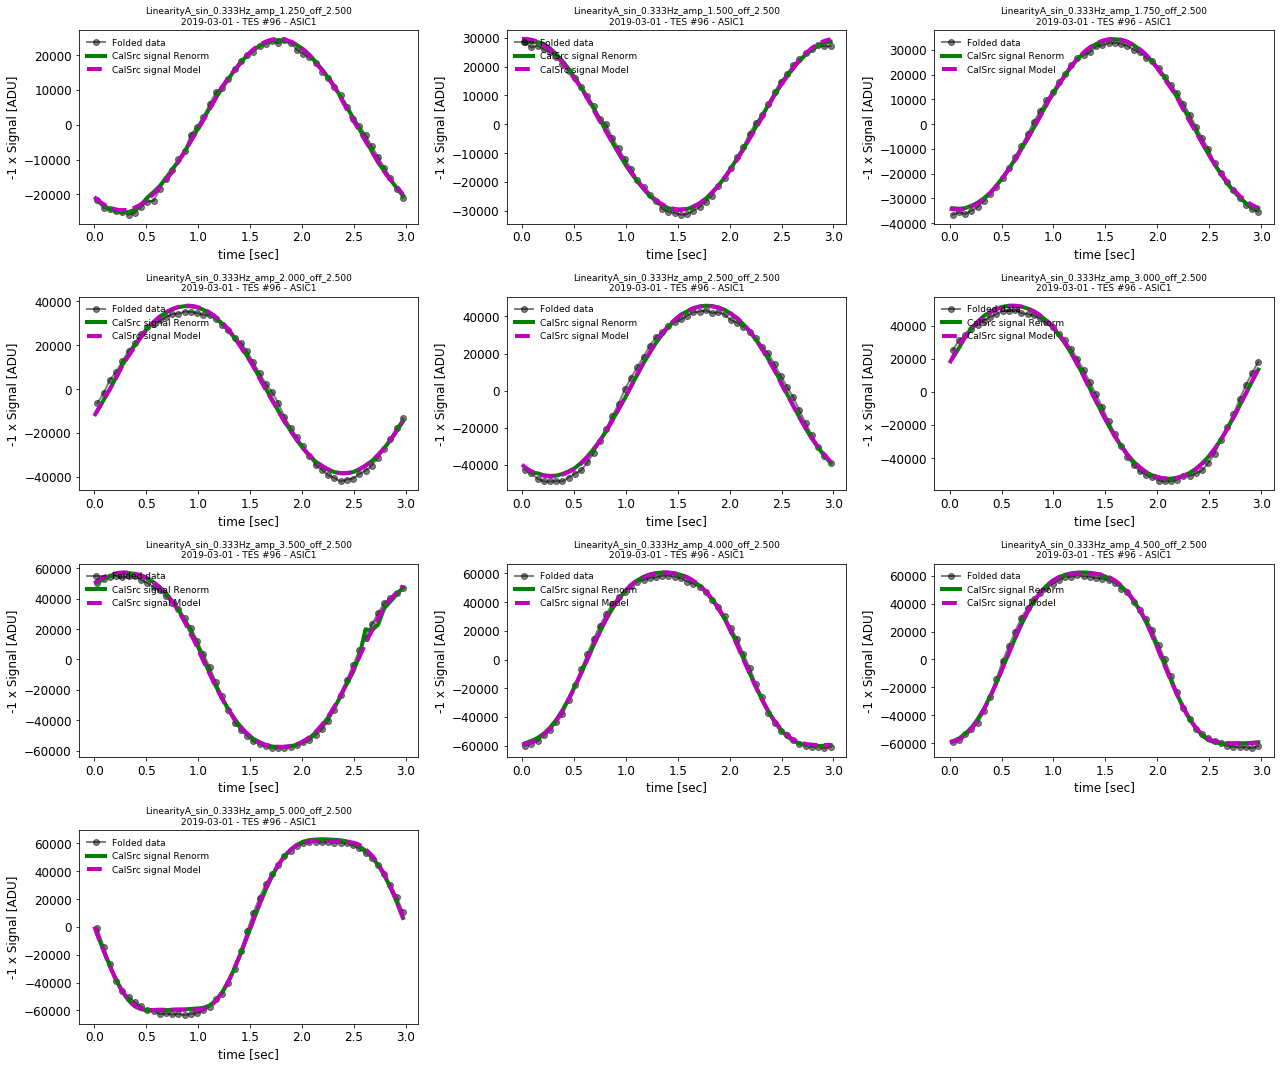

In [8]:
theASIC = 1
theTES = 96

asicindex = theASIC-1
tesindex = theTES-1
rc('figure',figsize=(18,15))
ttt = np.linspace(0,np.max(t),1000)
for ii in xrange(len(tt)):
    subplot(4,3,ii+1)
    p=plot(t,allfolded[ii,asicindex, tesindex, :],'ko-', lw=2, alpha=0.5,label='Folded data')
#     plot(ttt, ll.sine(ttt, allresfit[ii,asicindex, tesindex,:]),'r--', lw=2, 
#            label='Sine')
    p=plot(tsrc, ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 1./modulation_frequency] , 
                              allresfit_src[ii,asicindex, tesindex,:]),'g-', lw=4, label='CalSrc signal Renorm')
    p=plot(ttt, ll.sinesat(ttt, allresfit_src_model[ii,asicindex, tesindex,:]),'m--', lw=4, label='CalSrc signal Model')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(theTES, theASIC),fontsize=9)
    xlabel('time [sec]')
    ylabel('-1 x Signal [ADU]')
    legend(fontsize=9,frameon=False, loc='upper left')
tight_layout()

What we want is to see the output of the TES as a function of the input power. So this is what we do in the next cell. The input power can be chosen form the input sinewave (that does not contain the intrinsic non-linearity of the source) or the calsrc data. Of course the latter is the relevant one.

Below we plot the (amplitude, phase and offset adjusted - as above) input signal as a function of the TES measured signal. There are two cases (two lines in the plot below, left columns): 
- calibration source signal
- calibration source model

Each time we fit this data with a linear model and a logistic function model. 

In the case of the linear model one expects the slope to be constant if there is no saturation and to decrease when there is saturation. Therefore to be constant up to a certain modulation amplitude and start to decrease beyond the "non linear" limit. This is shown in the middle column. 

In the case of the logistic function fit, we plot the width of the logistic curve (parameter pars[2]) divided by the modulation amplitude of the source. Here it is expected to be large in the case of no saturation and decrease when entering in the saturation mode.

In [9]:
methods = ['CalSrc Signal', 'Model CalSrc Signal']
nbm = len(methods)

#### Linear fitting parameters
allres = np.zeros((nbm, 2,len(dirs), 2, 128))
allerr = np.zeros((nbm, 2,len(dirs), 2, 128))

#### Logistic fitting parameters
allres_logistic = np.zeros((nbm, 4,len(dirs), 2, 128))
allerr_logistic = np.zeros((nbm, 4,len(dirs), 2, 128))

for ii in xrange(len(dirs)):
    print('Directory {}/{} : {}'.format(ii+1, len(dirs), dirs[ii]))
    for asicindex in xrange(2):
        print('   Asic {}'.format(asicindex+1))
        for im in xrange(len(methods)):
            print('         Method = {}'.format(methods[im]))
            for tesindex in xrange(128):
                if methods[im]=='Fitted Sinewave':
                    params = allresfit[ii,asicindex, tesindex, :]
                    input_curve = ll.sine(t, params)
                elif methods[im]=='CalSrc Signal':
                    input_curve = ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 
                                                1./modulation_frequency], 
                                               allresfit_src[ii,asicindex, tesindex,:])/np.abs(allresfit_src[ii,asicindex, tesindex,0])
                elif methods[im] == 'Model CalSrc Signal':
                    input_curve = ll.sinesat(tsrc, 
                                             allresfit_src_model[ii,asicindex, tesindex,:])/np.abs(allresfit_src_model[ii,asicindex, tesindex,0])+0.5

                ### Fitting with a straight line
                res = ft.do_minuit(input_curve, allfolded[ii,asicindex, tesindex,:],np.zeros(len(t))+1., 
                       np.array([0.,10000.]), functname=ft.thepolynomial,verbose=False, force_chi2_ndf=True)
                allres[im, :,ii,asicindex, tesindex] = res[1]
                allerr[im, :,ii,asicindex, tesindex] = res[2]

                ### Fitting with an efficiency curve
                if ii ==0:
                    guess = np.array([2*np.max(allfolded[ii,asicindex, tesindex,:]),
                                      np.mean(input_curve),np.std(input_curve),
                                      np.min(allfolded[ii,asicindex, tesindex,:])])
                    #print(guess)
                else:
                    guess = allres_logistic[im, :, ii-1, asicindex, tesindex]
                res_logistic = ft.do_minuit(input_curve, allfolded[ii,asicindex, tesindex,:],np.zeros(len(t))+1., 
                       guess, functname=ll.logistic,verbose=False, force_chi2_ndf=True, nohesse=True)
                allres_logistic[im, :,ii,asicindex, tesindex] = res_logistic[1]
                allerr_logistic[im, :,ii,asicindex, tesindex] = res_logistic[2]
#                 print guess
#                 print res_logistic[1]
#                 print ''


Directory 1/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
   Asic 1
         Method = CalSrc Signal


lin_lib.py:28: RuntimeWarning: overflow encountered in exp
  return pars[3]+pars[0]*1./(1+np.exp(-(x-pars[1])/pars[2]))


         Method = Model CalSrc Signal
   Asic 2
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 2/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500
   Asic 1
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = CalSrc Signal


fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = nan
    c3 = nan

  m.migrad()


         Method = Model CalSrc Signal
Directory 3/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500
   Asic 1
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 4/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500
   Asic 1
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 5/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500
   Asic 1
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 6/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500
   Asic 1
         Method = Ca

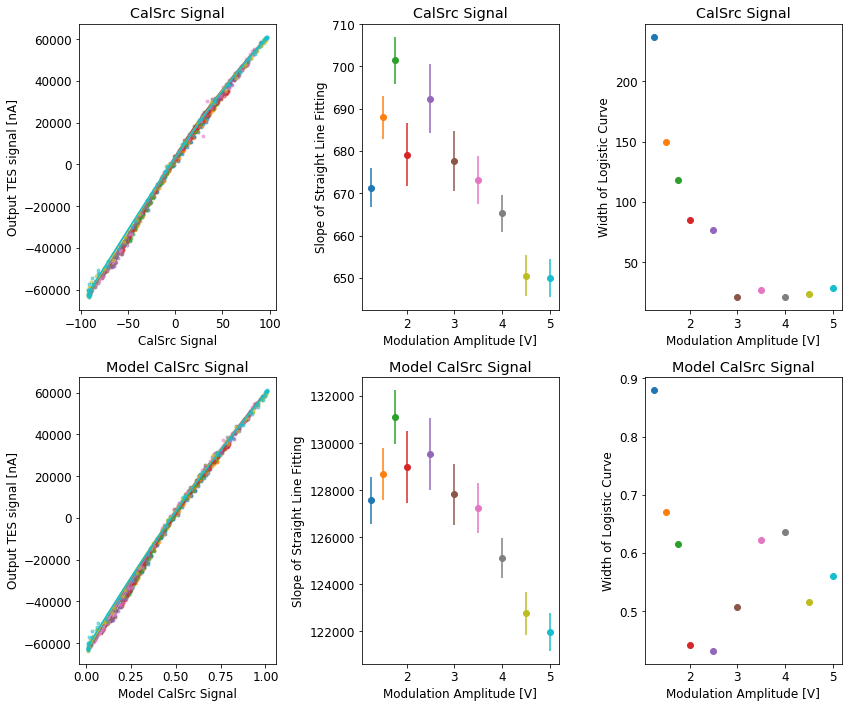

In [14]:
rc('figure',figsize=(12,10))
theASIC = 1
theTES = 96

asicindex = theASIC-1
tesindex = theTES-1
for im in xrange(len(methods)):
    for ii in xrange(len(dirs)):
        subplot(len(methods),3,3*im+1)
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,asicindex, tesindex,:]
            input_curve = ll.sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 
                                        1./modulation_frequency], 
                                       allresfit_src[ii,asicindex, tesindex,:])/np.abs(allresfit_src[ii,asicindex, tesindex,0])
        elif methods[im]=='Model CalSrc Signal':
            input_curve = ll.sinesat(tsrc, 
                                     allresfit_src_model[ii,asicindex, tesindex,:])/np.abs(allresfit_src_model[ii,asicindex, tesindex,0])+0.5

        p=plot(input_curve, allfolded[ii,asicindex, tesindex,:], '.', alpha=0.5)
        xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
        #plot(xxx, ft.thepolynomial(xxx, allres[:,ii]), color=p[0].get_color())
        plot(xxx, ll.logistic(xxx, allres_logistic[im, :,ii,asicindex, tesindex]), color=p[0].get_color())
        xlabel(methods[im])
        ylabel('Output TES signal [nA]')
        title(methods[im])
    
        subplot(len(methods),3,3*im+2)
        errorbar(amps[ii], allres[im, 0,ii,asicindex, tesindex], yerr=allerr[im, 0,ii,asicindex, tesindex],fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Slope of Straight Line Fitting')
        title(methods[im])

        subplot(len(methods),3,3*im+3)
        amp_width = allres_logistic[im, 2,ii,asicindex, tesindex] / amps[ii]
        err_amp_width = allerr_logistic[im, 2,ii,asicindex, tesindex]
        plot(amps[ii], amp_width,'o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Width of Logistic Curve')
        title(methods[im])

        tight_layout()

## Intercalibration of the TES

One can try to use the calibration factor observed here w.r.t. the CalSrc signal or its model to have an estimate of the intercalibration between TES.

This assumes that the signal is roughly uniform across the focal plane, which is probably not such a good approximation. But we have put Eccosorb on the window of the instrument to induce a maximum diffusion of the signal so that it's essentially not coherent. When doing so, the signal is observed on many bolometers.

Let's first display on the focal plane the amplitude of the fitted signal on the TES for our three models (sine, calsrc signal, calsrc model)

We choose ii=3 corresponding to 2.0V modulation amplitude.

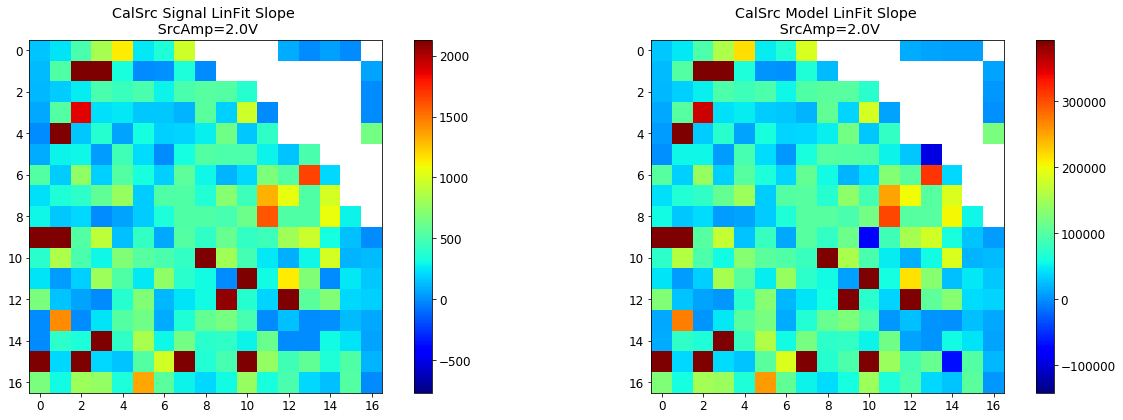

In [41]:
ii=3
nsig=1
rc('figure',figsize=(18,6))

subplot(1,2,1)
img=ft.image_asics(all1=np.ravel(allresfit_src[ii,:,:,0]))
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Signal LinFit Slope \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(1,2,2)
img=ft.image_asics(all1=np.ravel(allresfit_src_model[ii,:,:,0]))
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Model LinFit Slope \n SrcAmp={}V'.format(amps[ii]))
colorbar()

tight_layout()

We now divide this calibration factor by the median of the image (excluding non-physical pixels) in order to get an intercalibration map, we also the histogram of the intercalibrations.

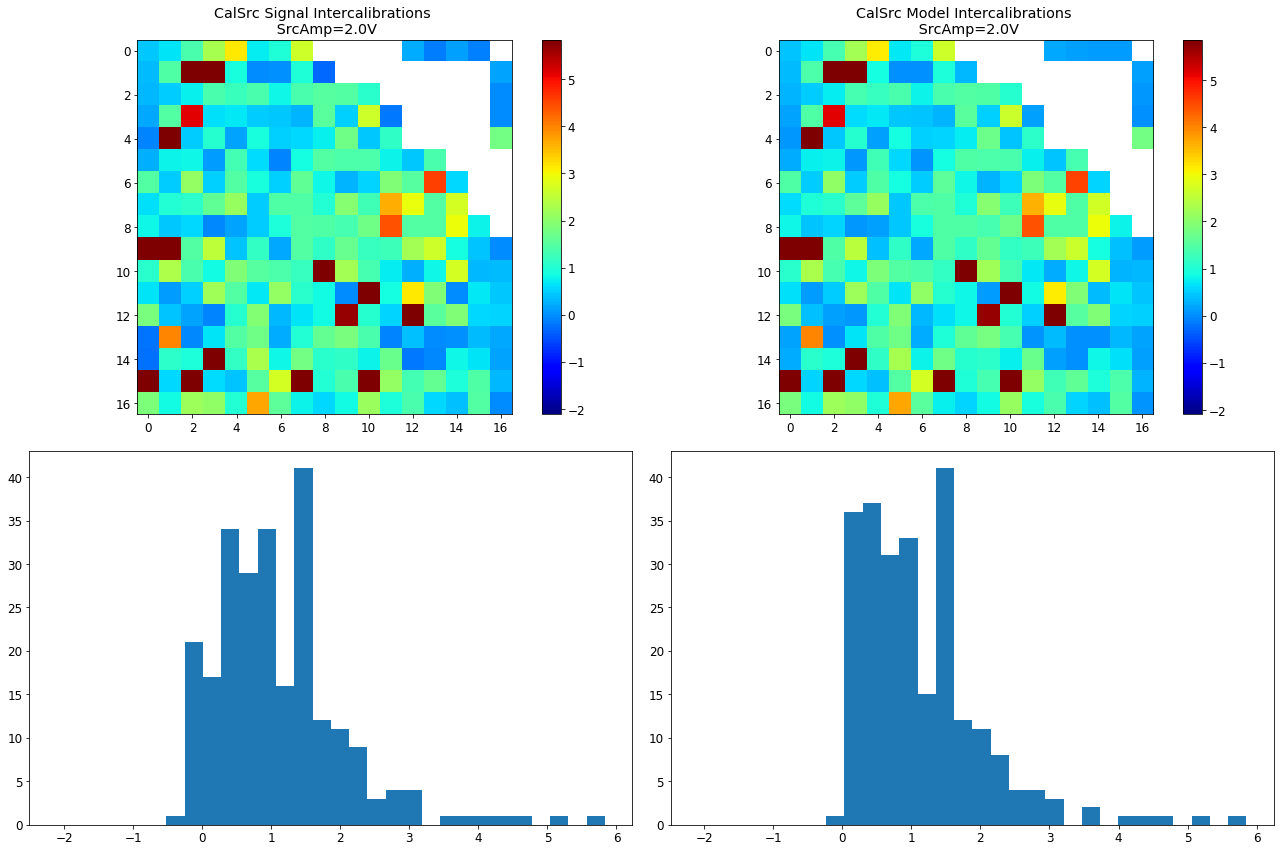

In [42]:
ii=3
nsig = 1
rc('figure',figsize=(18,12))

intercalibrations = np.zeros((2,256))

subplot(2,2,1)
calib_tes = np.ravel(allres[0, 0,ii,:, :])
intercalib_tes = calib_tes / np.median(calib_tes)
intercalibrations[0,:] = intercalib_tes
img=ft.image_asics(all1=intercalib_tes)
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Signal Intercalibrations \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(2,2,3)
hist(intercalib_tes,bins=30, range=[m-nsig*s, m+nsig*s])

subplot(2,2,2)
calib_tes = np.ravel(allres[1, 0,ii,:, :])
intercalib_tes = calib_tes / np.median(calib_tes)
intercalibrations[1,:] = intercalib_tes
img=ft.image_asics(all1=intercalib_tes)
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Model Intercalibrations \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(2,2,4)
hist(intercalib_tes,bins=30, range=[m-nsig*s, m+nsig*s])

tight_layout()

We write the calibration obtained with the CalSrc signal in a file:

In [43]:
from pysimulators import FitsArray
FitsArray(intercalibrations[0,:]).save('Intercal_Lin_CalSrc.fits')
FitsArray(intercalibrations[1,:]).save('Intercal_Lin_CalSrcModel.fits')

The we read the images of the source scanning made in early january

In [44]:
allimg = FitsArray('/Users/hamilton/Qubic/ExternalSource/allimg_scan_az.fits')
allaz = FitsArray('/Users/hamilton/Qubic/ExternalSource/az_scan_az.fits')

Here are the raw images, without this tentative intercalibration

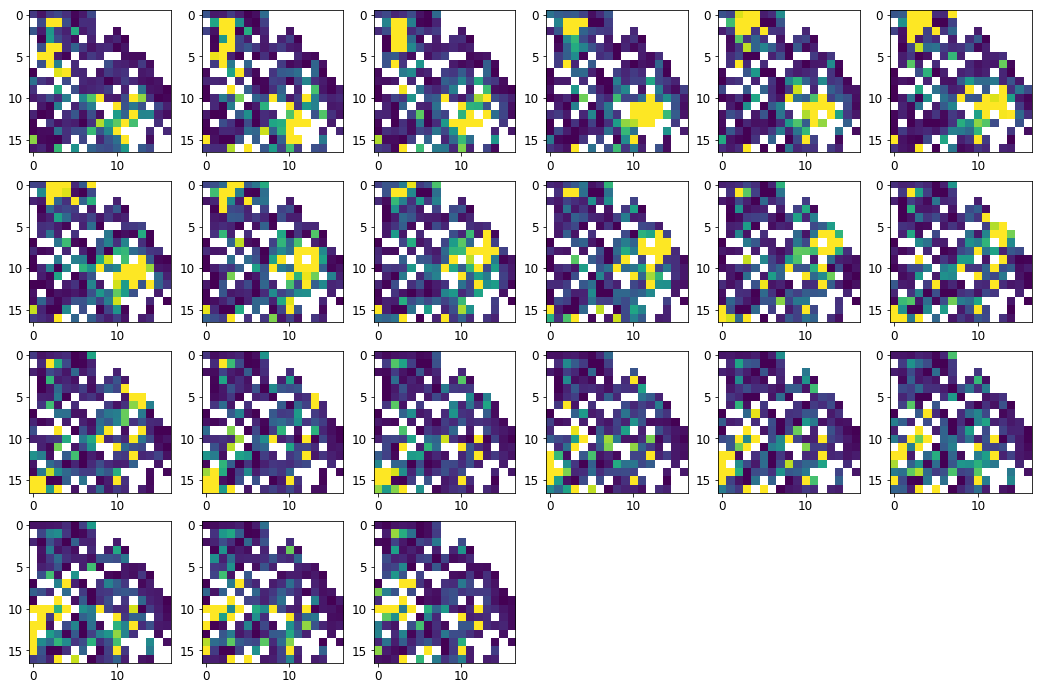

In [45]:
rc('figure',figsize=(18,12))
for i in xrange(21):
    subplot(4,6,i+1)
    imshow(allimg[i,:,:], cmap='viridis', vmin=0,vmax=500)


And here are the images with this tentative intercalibration

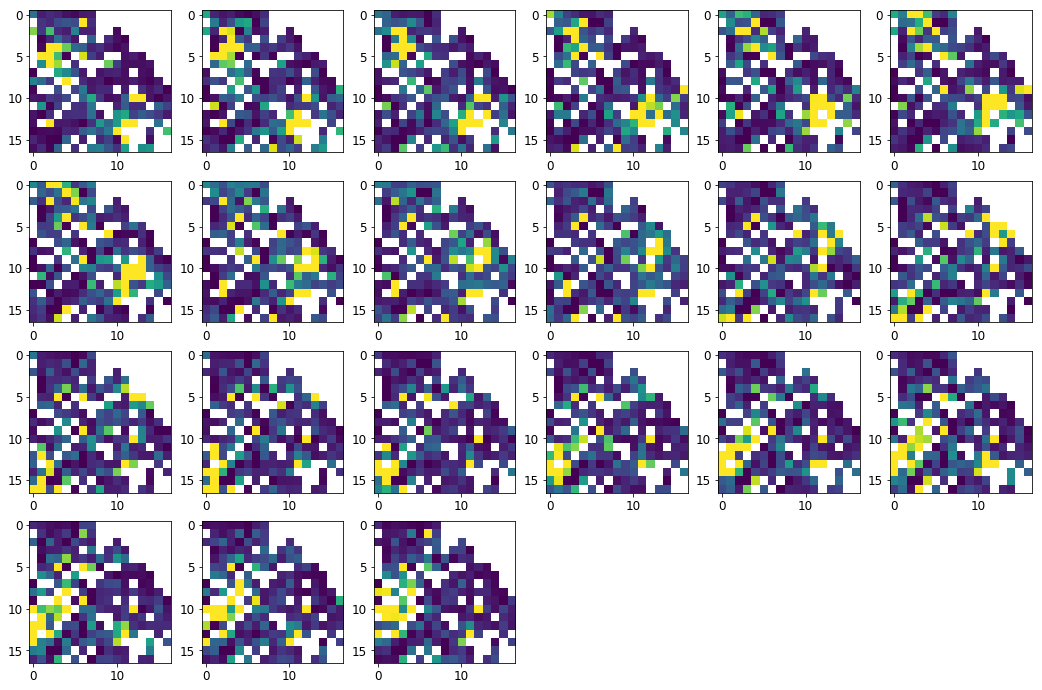

In [46]:
rc('figure',figsize=(18,12))
intercal_img = ft.image_asics(all1=intercalibrations[1,:])
for i in xrange(21):
    subplot(4,6,i+1)
    imshow(allimg[i,:,:]/intercal_img, cmap='viridis', vmin=0,vmax=500)


There seem to be an improvement although we are still limited by the fact that the field is not totally flat (the signal not being fully incoherent). Another issue is that in the intercalibration maps seen above, we do not see the radial decrease expected from the secondary beam of the horns on the focal plane: we should see less ADU signal on the TES for a given source power with TES away from the center... This is not seen here and is a concern.